In [11]:
from pathlib import Path

import rasterio as rio
import matplotlib.pyplot as plt
from rasterio.warp import Resampling, aligned_target
from rasterio.transform import array_bounds

import eda as eda
from luts import ice_zones, ice_years, ice_eras
from config import INPUT_DIR, BEAUFORT_DIR, CHUKCHI_DIR

/beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005 is identical.


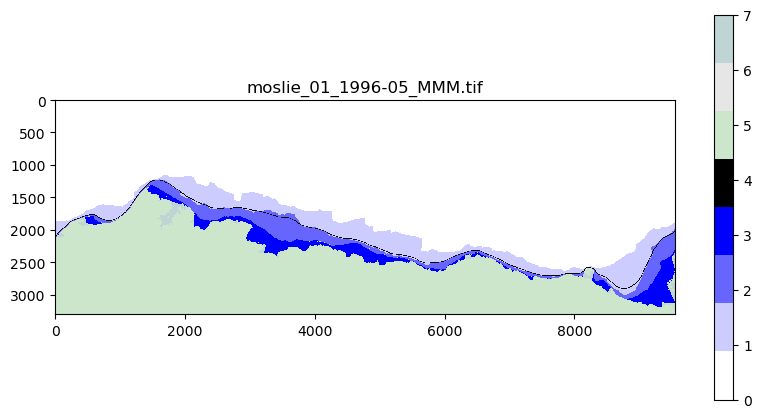

/beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_2005-2014
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_2005-2014 is identical.


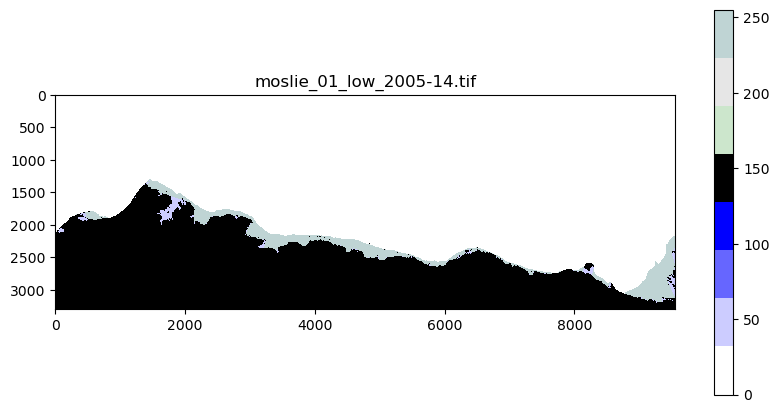

/beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023 is identical.


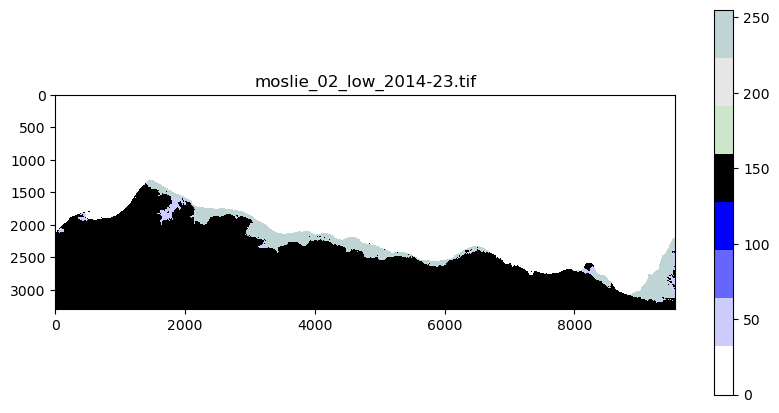

/beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005 is identical.


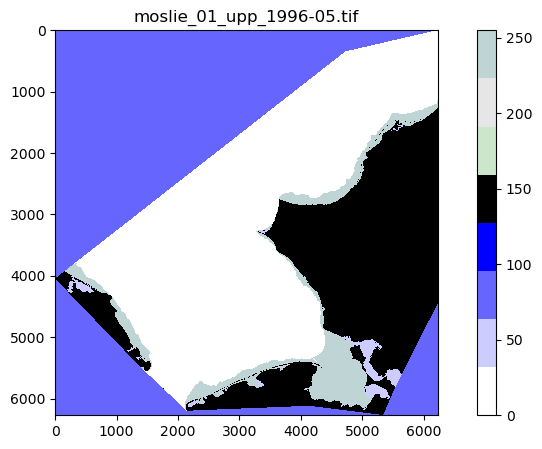

/beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2005-2014
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2005-2014 is identical.


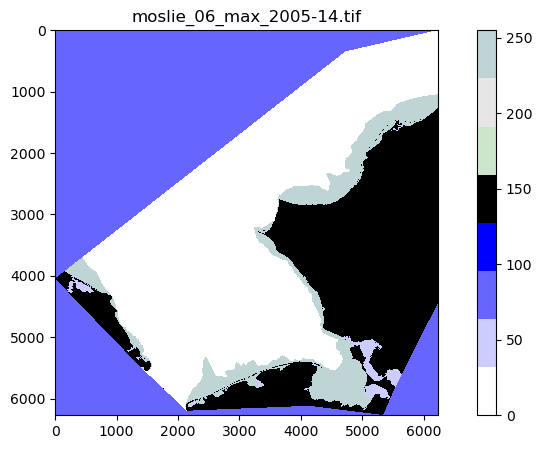

/beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023 is identical.


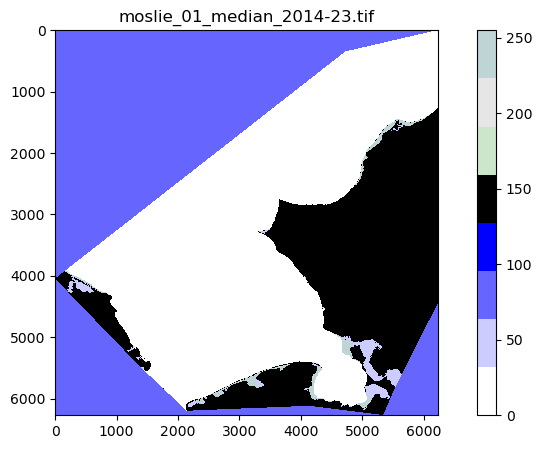

In [4]:
high_value_data_paths = []
for region in ice_zones:
    for era in ice_eras:
        high_value_data_paths.append(Path(INPUT_DIR / region / "AllSeasonsAnalysis2023" / f"MonthlySLIEs_{era}"))

for directory in high_value_data_paths:
    print(directory)
    eda.test_geotiff_metadata_for_conformity(directory, geotiff_metadata=None, str_to_match="MMM")
    eda.plot_random_sample(directory)

In [7]:
geotiffs_to_ingest = []
metas = []

for region in ice_zones:
    for era in ice_eras:
        target = Path(INPUT_DIR / region / "AllSeasonsAnalysis2023" / f"MonthlySLIEs_{era}")
        tiffs = eda.list_geotiffs(target, str_to_match="MMM")
        _, meta = eda.fetch_all_geotiff_metadata(target, str_to_match="MMM")
        geotiffs_to_ingest = geotiffs_to_ingest + tiffs
        metas = metas + meta
        
print(geotiffs_to_ingest[0], geotiffs_to_ingest[-1])

/beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005/moslie_06_1996-05_MMM.tif /beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023/moslie_06_2014-23_MMM.tif


In [8]:
metas[0]

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 9554, 'height': 3298, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",50],PARAMETER["longitude_of_center",-154],PARAMETER["standard_parallel_1",55],PARAMETER["standard_parallel_2",65],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(100.0, 0.0, -236180.0,
       0.0, -100.0, 2509919.0), 'blockxsize': 960, 'blockysize': 336, 'tiled': True, 'compress': 'packbits', 'interleave': 'band'}

In [14]:
def rename(fp):
    if "Chuk" == fp.parent.parent.parent.name:
        zone = "Chukchi"
        out_dir = CHUKCHI_DIR
    elif "Beau" == fp.parent.parent.parent.name:
        zone = "Beaufort"
        out_dir = BEAUFORT_DIR
    else:
        print(fp)
    
    fname = fp.name
    month = fname.split("_")[1]
    
    if "1996-05" in fname:
        era = "1996-2005"
    elif "2005-14" in fname:
        era = "2005-2014"
    elif "2014-23" in fname:
        era = "2014-2023"
    else:
        print(fp)
    
    new_name = f"{zone}_{month}_{era}_SLIE_MMM_summary.tif"
    new_fp = out_dir / new_name
    return new_fp

rename(geotiffs_to_ingest[0])

PosixPath('/beegfs/CMIP6/cparr4/landfast_sea_ice_products/Beaufort_MMM/Beaufort_06_1996-2005_SLIE_MMM_summary.tif')

In [17]:
tr = 100
dst_crs = rio.crs.CRS.from_epsg(3338)

def reproject_raster(file):

    with rio.open(file) as src:

        # compute the new affine transformation, width and height
        warp_transform, width, height = rio.warp.calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        # define the output raster profile
        out_profile = src.profile.copy()
        out_profile.update(
            {
                "crs": dst_crs,
                "transform": warp_transform,
                "width": width,
                "height": height,
                "bounds": array_bounds(height, width, warp_transform),
            }
        )

        # create the new raster file
        out_file = rename(file)
        
        with rio.open(out_file, "w", **out_profile) as dst:
            # reproject the input raster data
            rio.warp.reproject(
                source=src.read(1),
                destination=rio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=warp_transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,  # NN is default, but explicit here for easy change or experimentation later
            )


def tap_reproject_raster(file):
    with rio.open(file) as src:
        # compute the new affine transformation, width and height
        warp_transform, width, height = rio.warp.calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds, resolution=(tr, tr)
        )
        tap_transform, tap_width, tap_height = aligned_target(
            warp_transform, width, height, tr
        )
        
        # define the output raster profile
        out_profile = src.profile.copy()
        out_profile.update(
            {
                "crs": dst_crs,
                "transform": tap_transform,
                "width": tap_width,
                "height": tap_height,
                "bounds": array_bounds(tap_height, tap_width, tap_transform),
            }
        )

        # create the new raster file name
        out_file = rename(file)

        with rio.open(out_file, "w", **out_profile) as dst:
            # reproject the input raster data
            rio.warp.reproject(
                source=src.read(1),
                destination=rio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=tap_transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,  # NN is default, but explicit here for easy change or experimentation later
            )

In [18]:
for tiff in geotiffs_to_ingest:
    tap_reproject_raster(tiff)

In [22]:
!echo $BEAUFORT_DIR

/beegfs/CMIP6/cparr4/landfast_sea_ice_products/Beaufort_MMM


In [19]:
!ls $BEAUFORT_DIR

Beaufort_01_1996-2005_SLIE_MMM_summary.tif
Beaufort_01_2005-2014_SLIE_MMM_summary.tif
Beaufort_01_2014-2023_SLIE_MMM_summary.tif
Beaufort_02_1996-2005_SLIE_MMM_summary.tif
Beaufort_02_2005-2014_SLIE_MMM_summary.tif
Beaufort_02_2014-2023_SLIE_MMM_summary.tif
Beaufort_03_1996-2005_SLIE_MMM_summary.tif
Beaufort_03_2005-2014_SLIE_MMM_summary.tif
Beaufort_03_2014-2023_SLIE_MMM_summary.tif
Beaufort_04_1996-2005_SLIE_MMM_summary.tif
Beaufort_04_2005-2014_SLIE_MMM_summary.tif
Beaufort_04_2014-2023_SLIE_MMM_summary.tif
Beaufort_05_1996-2005_SLIE_MMM_summary.tif
Beaufort_05_2005-2014_SLIE_MMM_summary.tif
Beaufort_05_2014-2023_SLIE_MMM_summary.tif
Beaufort_06_1996-2005_SLIE_MMM_summary.tif
Beaufort_06_2005-2014_SLIE_MMM_summary.tif
Beaufort_06_2014-2023_SLIE_MMM_summary.tif
Beaufort_07_1996-2005_SLIE_MMM_summary.tif
Beaufort_07_2005-2014_SLIE_MMM_summary.tif
Beaufort_07_2014-2023_SLIE_MMM_summary.tif
Beaufort_10_1996-2005_SLIE_MMM_summary.tif
Beaufort_10_2005-2014_SLIE_MMM_summary.tif
Beaufort_10

In [20]:
!ls $CHUKCHI_DIR

Chukchi_01_1996-2005_SLIE_MMM_summary.tif
Chukchi_01_2005-2014_SLIE_MMM_summary.tif
Chukchi_01_2014-2023_SLIE_MMM_summary.tif
Chukchi_02_1996-2005_SLIE_MMM_summary.tif
Chukchi_02_2005-2014_SLIE_MMM_summary.tif
Chukchi_02_2014-2023_SLIE_MMM_summary.tif
Chukchi_03_1996-2005_SLIE_MMM_summary.tif
Chukchi_03_2005-2014_SLIE_MMM_summary.tif
Chukchi_03_2014-2023_SLIE_MMM_summary.tif
Chukchi_04_1996-2005_SLIE_MMM_summary.tif
Chukchi_04_2005-2014_SLIE_MMM_summary.tif
Chukchi_04_2014-2023_SLIE_MMM_summary.tif
Chukchi_05_1996-2005_SLIE_MMM_summary.tif
Chukchi_05_2005-2014_SLIE_MMM_summary.tif
Chukchi_05_2014-2023_SLIE_MMM_summary.tif
Chukchi_06_1996-2005_SLIE_MMM_summary.tif
Chukchi_06_2005-2014_SLIE_MMM_summary.tif
Chukchi_06_2014-2023_SLIE_MMM_summary.tif
Chukchi_07_1996-2005_SLIE_MMM_summary.tif
Chukchi_07_2005-2014_SLIE_MMM_summary.tif
Chukchi_10_1996-2005_SLIE_MMM_summary.tif
Chukchi_10_2005-2014_SLIE_MMM_summary.tif
Chukchi_10_2014-2023_SLIE_MMM_summary.tif
Chukchi_11_1996-2005_SLIE_MMM_summ

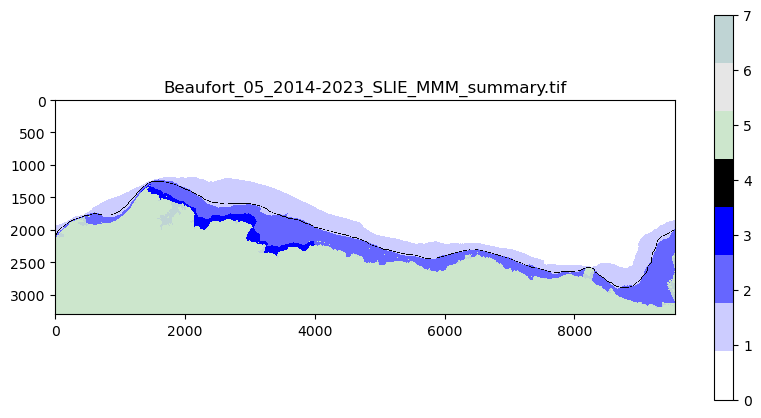

In [5]:
eda.plot_random_sample(BEAUFORT_DIR)

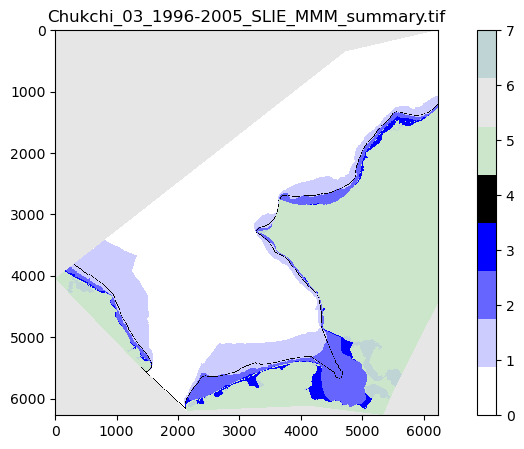

In [10]:
eda.plot_random_sample(CHUKCHI_DIR)

In [14]:
# number of files should 10 months * 3 era in each directory
assert len(eda.list_geotiffs(BEAUFORT_DIR)) == 30
assert len(eda.list_geotiffs(CHUKCHI_DIR)) == 30

AssertionError: 